<h2>Import Libraries</h2>

In [57]:
import pandas as pd #data preprocessing
import numpy as np
import itertools
import string

#for cross validation and model selection
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score

#base models
##linear and kernel based methods
from sklearn.linear_model import LogisticRegression

##tree-based models 
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

##boosted algorithms 
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

##for deep neural networks
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers.legacy import Adam, RMSprop
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics 

import matplotlib.pyplot as plt
import seaborn as sns

##tensor networks
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

#for preprocessing data
from sklearn.preprocessing import OneHotEncoder


##metrics 
#metrics for model evaluation and validation
from sklearn.metrics import f1_score, roc_auc_score, matthews_corrcoef, recall_score, precision_score
from sklearn.metrics import balanced_accuracy_score, auc, roc_curve, precision_recall_curve, log_loss, average_precision_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn.calibration import calibration_curve, CalibrationDisplay
from sklearn.metrics import balanced_accuracy_score
import time
%matplotlib inline
#To show all the rows of pandas dataframe
pd.set_option('display.max_rows', None)

#for hyperparameter optimization
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import train_test_split

#model explainabilty
import shap

import os 
import time

import warnings
warnings.filterwarnings('ignore')

In [58]:
!pip install --upgrade openpyxl

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


<h2>Load the Data</h2>

In [59]:
insurance_df = pd.read_excel(r"C:\Users\mpumi\Desktop\Nomagugu EDSA\Integrated Project\Dataset\insurance_claims_raw (1).xlsx")
insurance_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported,_c39
0,328,48.0,521585,2014-10-17,OH,250/500,1000.0,1406.91,0,466132,...,YES,71610.0,6510.0,13020.0,52080,Saab,92x,2004,Y,NaN
1,228,42.0,342868,2006-06-27,IN,250/500,2000.0,1197.22,5000000,468176,...,?,5070.0,780.0,780.0,3510,Mercedes,E400,2007,Y,NaN
2,134,29.0,687698,2000-09-06,OH,100/300,2000.0,1413.14,5000000,430632,...,NO,34650.0,7700.0,3850.0,23100,Dodge,RAM,2007,N,NaN
3,256,41.0,227811,1990-05-25,IL,250/500,2000.0,1415.74,6000000,608117,...,NO,63400.0,6340.0,6340.0,50720,Chevrolet,Tahoe,2014,Y,NaN
4,228,44.0,367455,2014-06-06,IL,500/1000,1000.0,1583.91,6000000,610706,...,NO,6500.0,1300.0,650.0,4550,Accura,RSX,2009,N,NaN


In [60]:
print('The training dataset has {} samples and {} features.'.format(insurance_df.shape[0], insurance_df.shape[1]-1))

The training dataset has 1000 samples and 39 features.


<h2>EDA on Insurance Claims Data</h2>

<h2>Data Cleaning</h2>

In [61]:
insurance_df = insurance_df.drop(columns =['_c39'])
insurance_df.head()

,months_as_customer,age,policy_number,policy_bind_date,policy_state,policy_csl,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,...,witnesses,police_report_available,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48.0,521585,2014-10-17,OH,250/500,1000.0,1406.91,0,466132,...,2,YES,71610.0,6510.0,13020.0,52080,Saab,92x,2004,Y
1,228,42.0,342868,2006-06-27,IN,250/500,2000.0,1197.22,5000000,468176,...,0,?,5070.0,780.0,780.0,3510,Mercedes,E400,2007,Y
2,134,29.0,687698,2000-09-06,OH,100/300,2000.0,1413.14,5000000,430632,...,3,NO,34650.0,7700.0,3850.0,23100,Dodge,RAM,2007,N
3,256,41.0,227811,1990-05-25,IL,250/500,2000.0,1415.74,6000000,608117,...,2,NO,63400.0,6340.0,6340.0,50720,Chevrolet,Tahoe,2014,Y
4,228,44.0,367455,2014-06-06,IL,500/1000,1000.0,1583.91,6000000,610706,...,1,NO,6500.0,1300.0,650.0,4550,Accura,RSX,2009,N


In [62]:
# Handle missing values
insurance_df.replace('?', pd.NA, inplace=True)

In [63]:
# Convert policy_bind_date to datetime
insurance_df['policy_bind_date'] = pd.to_datetime(insurance_df['policy_bind_date'])


In [64]:
# Extract year, month, day from policy_bind_date
insurance_df['policy_bind_year'] = insurance_df['policy_bind_date'].dt.year
insurance_df['policy_bind_month'] = insurance_df['policy_bind_date'].dt.month
insurance_df['policy_bind_day'] = insurance_df['policy_bind_date'].dt.day
insurance_df.drop(columns='policy_bind_date', inplace=True)

In [65]:
# One-hot encode categorical variables
insurance_df = pd.get_dummies(insurance_df, drop_first=True)

In [66]:
# Handle missing values (e.g., using fillna with a strategy, here filling with mean for simplicity)
insurance_df.fillna(insurance_df.mean(), inplace=True)

In [67]:
# Separate features and target
X = insurance_df.drop(columns='fraud_reported_Y')
y = insurance_df['fraud_reported_Y']


In [68]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [69]:
insurance_df.shape

(1000, 1146)

In [70]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 1146 entries, months_as_customer to fraud_reported_Y
dtypes: bool(1124), datetime64[ns](1), float64(7), int32(3), int64(11)
memory usage: 1.2 MB


In [71]:
insurance_df.isnull().sum()

months_as_customer                           0
age                                          0
policy_number                                0
policy_deductable                            0
policy_annual_premium                        0
umbrella_limit                               0
insured_zip                                  0
capital-gains                                0
capital-loss                                 0
incident_date                                0
incident_hour_of_the_day                     0
number_of_vehicles_involved                  0
bodily_injuries                              0
witnesses                                    0
total_claim_amount                           0
injury_claim                                 0
property_claim                               0
vehicle_claim                                0
auto_year                                    0
policy_bind_year                             0
policy_bind_month                            0
policy_bind_d

In [72]:
insurance_df.isna().sum().sum()

0

In [73]:
insurance_df.head(10)

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_date,...,auto_model_RAM,auto_model_RSX,auto_model_Silverado,auto_model_TL,auto_model_Tahoe,auto_model_Ultima,auto_model_Wrangler,auto_model_X5,auto_model_X6,fraud_reported_Y
0,328,48.0,521585,1000.0,1406.91,0,466132,53300.0,0,2015-01-25,...,False,False,False,False,False,False,False,False,False,True
1,228,42.0,342868,2000.0,1197.22,5000000,468176,0.0,0,2015-01-21,...,False,False,False,False,False,False,False,False,False,True
2,134,29.0,687698,2000.0,1413.14,5000000,430632,35100.0,0,2015-02-22,...,True,False,False,False,False,False,False,False,False,False
3,256,41.0,227811,2000.0,1415.74,6000000,608117,48900.0,-62400,2015-01-10,...,False,False,False,False,True,False,False,False,False,True
4,228,44.0,367455,1000.0,1583.91,6000000,610706,66000.0,-46000,2015-02-17,...,False,True,False,False,False,False,False,False,False,False
5,256,39.0,104594,1000.0,1351.10,0,478456,0.0,0,2015-01-02,...,False,False,False,False,False,False,False,False,False,True
6,137,34.0,413978,1000.0,1333.35,0,441716,0.0,-77000,2015-01-13,...,False,False,False,False,False,False,False,False,False,False
7,165,37.0,429027,1000.0,1137.03,0,603195,0.0,0,2015-02-27,...,False,False,False,False,False,False,False,False,False,False
8,27,33.0,485665,500.0,1442.99,0,601734,0.0,0,2015-01-30,...,False,False,False,False,False,False,False,False,False,False
9,212,42.0,636550,500.0,1315.68,0,600983,0.0,-39300,2015-01-05,...,False,False,False,False,False,False,False,False,False,False


In [74]:
insurance_df.describe()

,months_as_customer,age,policy_number,policy_deductable,policy_annual_premium,umbrella_limit,insured_zip,capital-gains,capital-loss,incident_date,...,bodily_injuries,witnesses,total_claim_amount,injury_claim,property_claim,vehicle_claim,auto_year,policy_bind_year,policy_bind_month,policy_bind_day
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1.000000e+03,1000.000000,1000.000000,1000.000000,1000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,203.954000,38.962926,546238.648000,1134.268537,1257.001113,1.101000e+06,501214.488000,25176.452906,-26793.700000,2015-01-30 08:02:24,...,0.992000,1.487000,52767.469880,7434.944945,7398.628629,37928.950000,2005.103000,2001.604000,6.559000,15.448000
min,0.000000,19.000000,100804.000000,500.000000,433.330000,-1.000000e+06,430104.000000,0.000000,-111100.000000,2015-01-01 00:00:00,...,0.000000,0.000000,100.000000,0.000000,0.000000,70.000000,1995.000000,1990.000000,1.000000,1.000000
25%,115.750000,32.000000,335980.250000,500.000000,1090.567500,0.000000e+00,448404.500000,0.000000,-51500.000000,2015-01-15 00:00:00,...,0.000000,1.000000,41962.500000,4295.000000,4445.000000,30292.500000,2000.000000,1995.000000,3.000000,8.000000
50%,199.500000,38.000000,533135.000000,1000.000000,1257.200000,0.000000e+00,466445.500000,0.000000,-23250.000000,2015-01-31 00:00:00,...,1.000000,1.000000,57880.000000,6780.000000,6750.000000,42100.000000,2005.000000,2002.000000,7.000000,16.000000
75%,276.250000,44.000000,759099.750000,2000.000000,1415.695000,0.000000e+00,603251.000000,51025.000000,0.000000,2015-02-15 00:00:00,...,2.000000,2.000000,70532.500000,11305.000000,10885.000000,50822.500000,2010.000000,2008.000000,10.000000,23.000000
max,479.000000,64.000000,999435.000000,2000.000000,2047.590000,1.000000e+07,620962.000000,100500.000000,0.000000,2015-03-01 00:00:00,...,2.000000,3.000000,114920.000000,21450.000000,23670.000000,79560.000000,2015.000000,2015.000000,12.000000,31.000000
std,115.113174,9.126276,257063.005276,610.639744,243.898011,2.297407e+06,71701.610941,27849.459762,28104.096686,NaN,...,0.820127,1.111335,26352.431456,4880.713630,4824.634340,18886.252893,6.015861,7.360391,3.499824,8.808001


In [75]:
insurance_df.age.describe()

count    1000.000000
mean       38.962926
std         9.126276
min        19.000000
25%        32.000000
50%        38.000000
75%        44.000000
max        64.000000
Name: age, dtype: float64

In [76]:
# Display the first few rows of X_train and y_train to verify the split
print(X_train.head())
print(y_train.head())

     months_as_customer   age  policy_number  policy_deductable  \
29                  241  45.0         596785             2000.0   
535                  65  23.0         876699             1000.0   
695                 289  45.0         943425             2000.0   
557                  63  26.0         550930              500.0   
836                 257  43.0         797636             1000.0   

     policy_annual_premium  umbrella_limit  insured_zip  capital-gains  \
29                 1104.50               0       432211            0.0   
535                1099.95               0       473109            0.0   
695                1221.41               0       466289        46700.0   
557                1500.04         6000000       613826            0.0   
836                 974.84               0       468984        52100.0   

     capital-loss incident_date  ...  auto_model_Pathfinder  auto_model_RAM  \
29              0    2015-02-15  ...                  False           Fal

In [79]:
def convert_datetime_features(df):
    for col in df.columns:
        if np.issubdtype(df[col].dtype, np.datetime64):
            df[col] = df[col].astype('int64') / 10**9  # Convert to seconds since epoch
    return df

# Apply the function to the train and test sets
X_train = convert_datetime_features(X_train)
X_test = convert_datetime_features(X_test)



In [80]:
def check_and_convert_types(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            try:
                df[col] = df[col].astype(float)
            except ValueError:
                print(f"Column {col} cannot be converted to float directly.")
    return df

X_train = check_and_convert_types(X_train)
X_test = check_and_convert_types(X_test)


In [81]:
X_train.fillna(0, inplace=True)
X_test.fillna(0, inplace=True)


<h2>Baseline Model</h2>

In [91]:

base_clf = LogisticRegression(max_iter=1000, penalty='l1', solver='saga', class_weight='balanced')

name = 'Baseline (Logistic Regression)'

start = time.time()

base_clf.fit(X_train, y_train)

y_pred = base_clf.predict(X_test)

scores = balanced_accuracy_score(y_test, y_pred)

end = time.time()

print(f"{name} - Time taken: {end - start:.2f}s - Balanced Accuracy: {scores:.2f}")


Baseline (Logistic Regression) - Time taken: 16.48s - Balanced Accuracy: 0.45


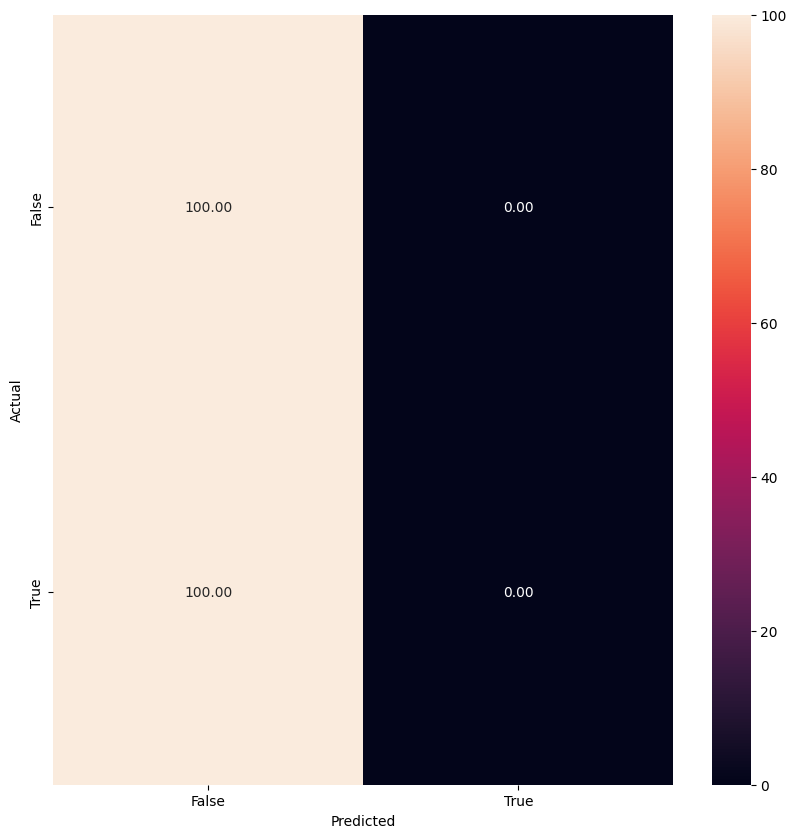

-------------------------Baseline (Random Forest)---------------------------------
---------------------Classification Report-----------------------
              precision    recall  f1-score   support

       False       0.72      1.00      0.84       145
        True       0.00      0.00      0.00        55

    accuracy                           0.73       200
   macro avg       0.36      0.50      0.42       200
weighted avg       0.53      0.72      0.61       200

-------------------------Ensemble Method------------------------
Balanced Accruacy: 0.5
-------------------------Run Time------------------------
Total Run Time: 1718785718.8691585
------------------------Confusion Matrix--------------------


In [85]:
cm = 100*confusion_matrix(y_test, y_pred, normalize= 'true')
# cm = 100*cm.astype('float')/cm.sum()
fig, ax = plt.subplots(figsize = (10,10))
sns.heatmap(cm, annot = True, fmt = '.2f', xticklabels= base_clf.classes_, yticklabels= base_clf.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show(block=False)

print(f"-------------------------{name}---------------------------------")
print("---------------------Classification Report-----------------------")
print(classification_report(y_test, y_pred))
print("-------------------------Ensemble Method------------------------")
print('Balanced Accruacy:', scores)
print("-------------------------Run Time------------------------")
print('Total Run Time:',end)
print("------------------------Confusion Matrix--------------------")

<h2>Hyperameter Tuning using Bayesian Optimisation<h2> 

In [87]:
#calculate class weights 
y_train_array = np.array(insurance_df['Default'])

#calculate class weights
class_weights = compute_class_weight(class_weight='balanced', classes= np.unique(y_train), y = y_train)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

KeyError: 'Default'

In [ ]:
<h2>Data Visualisation</h2>

In [ ]:
import matplotlib.pyplto